In [1]:
# Import the necessary libraries
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from itertools import groupby
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import spacy
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.stem.lancaster import LancasterStemmer
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ozgur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Read in the train, test, and sample submission data from the 'data' directory
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')
train1 = train

In [3]:
# Select all columns from the third column onwards in the train DataFrame
x=train.iloc[:,2:].sum()
rowsums=train.iloc[:,2:].sum(axis=1)

# Add a new column to the train DataFrame called 'nontoxic' that contains a boolean value indicating
# whether or not the comment is toxic
train['nontoxic']=(rowsums==0)

In [4]:
# Create a new column called "istoxic" in the "train" data frame
# if a value in the "nontoxic" column is True, the corresponding value in the
# "istoxic" column will be False, and vice versa
train['istoxic'] = ~train['nontoxic']
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,False


In [5]:
# Display the first 10 rows of the "train" data frame using the head() method
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,True,False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,True,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,True,False
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,True,False


In [6]:
# From now on data frame called "train" will contain only 
# the "id", "comment_text", and "istoxic" columns from the original "train" data frame
train = train[['id', 'comment_text', 'istoxic']]
train1 = train #To keep this DataFrame for another model
train.head(10)

,id,comment_text,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False
9,00040093b2687caa,alignment on this subject and which are contra...,False


## EDA

In [7]:
#Transforming all the words to lower case
toxic_comment = train[train['istoxic'] == 1]['comment_text'].str.lower()
nontoxic_comment = train[train['istoxic'] == 0]['comment_text'].str.lower()

In [8]:
#Transforming the comments to a list
toxic_comment = toxic_comment.values.tolist()
nontoxic_comment = nontoxic_comment.values.tolist()

In [9]:
#Tokenizing the words
toxic_comment_break = [nltk.tokenize.wordpunct_tokenize(text) for text in toxic_comment]
nontoxic_comment_break = [nltk.tokenize.wordpunct_tokenize(text) for text in nontoxic_comment]

In [10]:
#Deleting common English words
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
#Defining a function to delete repeated characters in words
def clear_multiple_char(comment):        
    ti = []
    for words in comment:
        t = [''.join(["".join(i) for i, _ in groupby(word)]) if len(word)>10 else word for word in words]
        ti.append(t)
    return ti

In [12]:
toxic_comment_break = clear_multiple_char(toxic_comment_break)
nontoxic_comment_break = clear_multiple_char(nontoxic_comment_break)

In [13]:
#Eliminating punctuations and numbers
stemmer = LancasterStemmer()
punctuation = string.punctuation # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# Add numbers
punctuation += '0123456789'

#Defining the function to eliminate punctuations and numbers
def comment_raiz(comment):
    text = []
    for lista in comment:
        valids = [stemmer.stem(word) for word in lista if word not in stopwords and word not in punctuation 
                  and len(word)>2]
        valids_true = [''.join([char for char in word if char not in punctuation]) for word in valids if 
                       len(''.join([char for char in word if char not in punctuation]))>0]
        text.append(valids_true)
    return text

In [14]:
# Apply the "comment_raiz" function on toxic_comment_break and nontoxic_comment_break
toxic_comment_clear = comment_raiz(toxic_comment_break)
nontoxic_comment_clear = comment_raiz(nontoxic_comment_break)

In [15]:
#Define the function that counts number of occurance of each word in the comments
def counter(comment_clear):
    cnt = Counter()
    for words in comment_clear:
        for word in words:
            cnt[word] += 1
    return cnt

In [16]:
toxic_comment_cnt = counter(toxic_comment_clear)
nontoxic_comment_cnt = counter(nontoxic_comment_clear)

In [17]:
#Define the function that plots 20 most common words
def top_twenty(counts, label):
    most_common = collections.Counter(counts).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=words, y=counts)
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

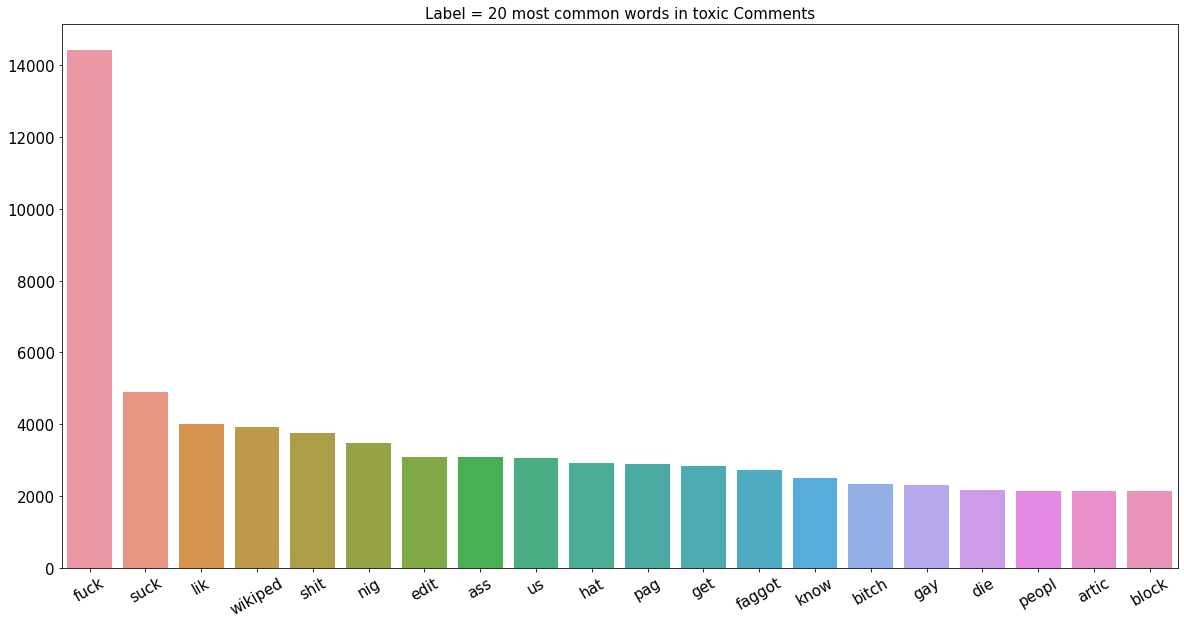

In [18]:
top_twenty(toxic_comment_cnt, label='20 most common words in toxic Comments')

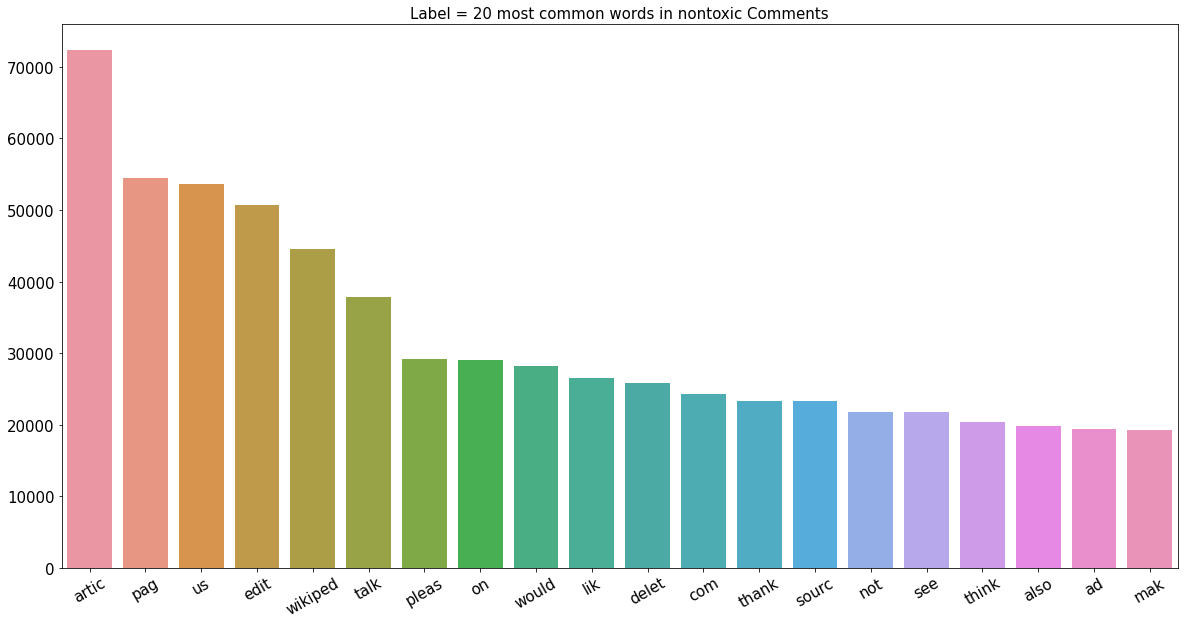

In [19]:
top_twenty(nontoxic_comment_cnt, label='20 most common words in nontoxic Comments')

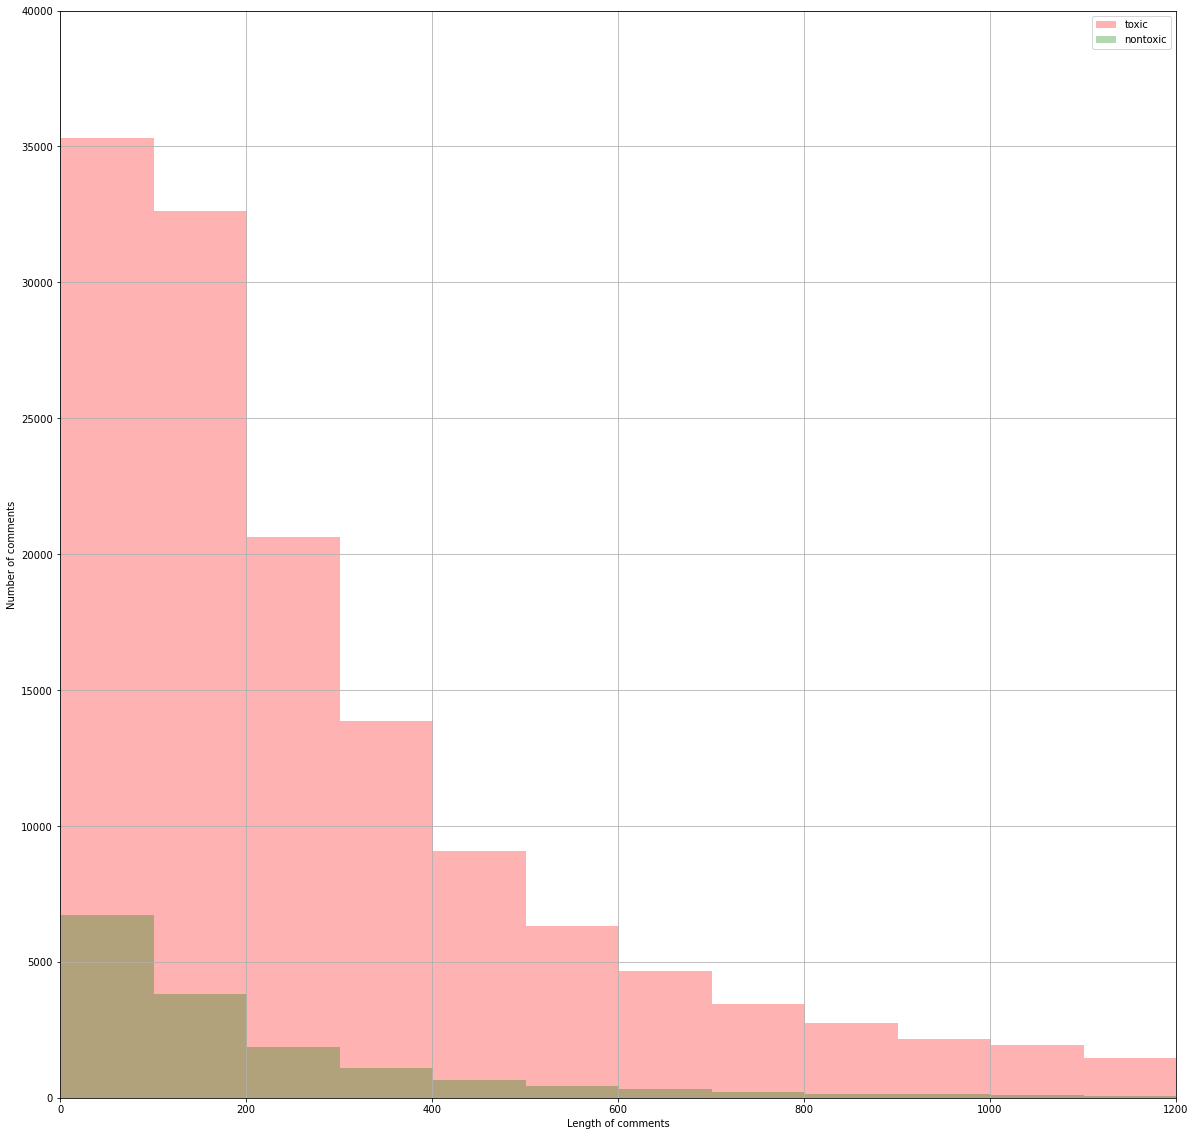

In [20]:
# Create the figure
plt.figure(figsize=(20,20))

# Get the data for the first plot
label = train[['istoxic']]
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    if label['istoxic'].iloc[ix] == 0:
        y[ix][0] = l

# Create the first plot
plt.hist(y, bins=range(1, 8000, 100), label='toxic', color='red', alpha=0.3)

# Get the data for the second plot
label = train[['istoxic']]
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    if label['istoxic'].iloc[ix] == 1:
        y[ix][0] = l

# Create the second plot
plt.hist(y, bins=range(1, 8000, 100), label='nontoxic', color='green', alpha=0.3)

# Set the x and y axis limits
plt.axis([0, 1200, 0, 40000])

# Set the x and y labels
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

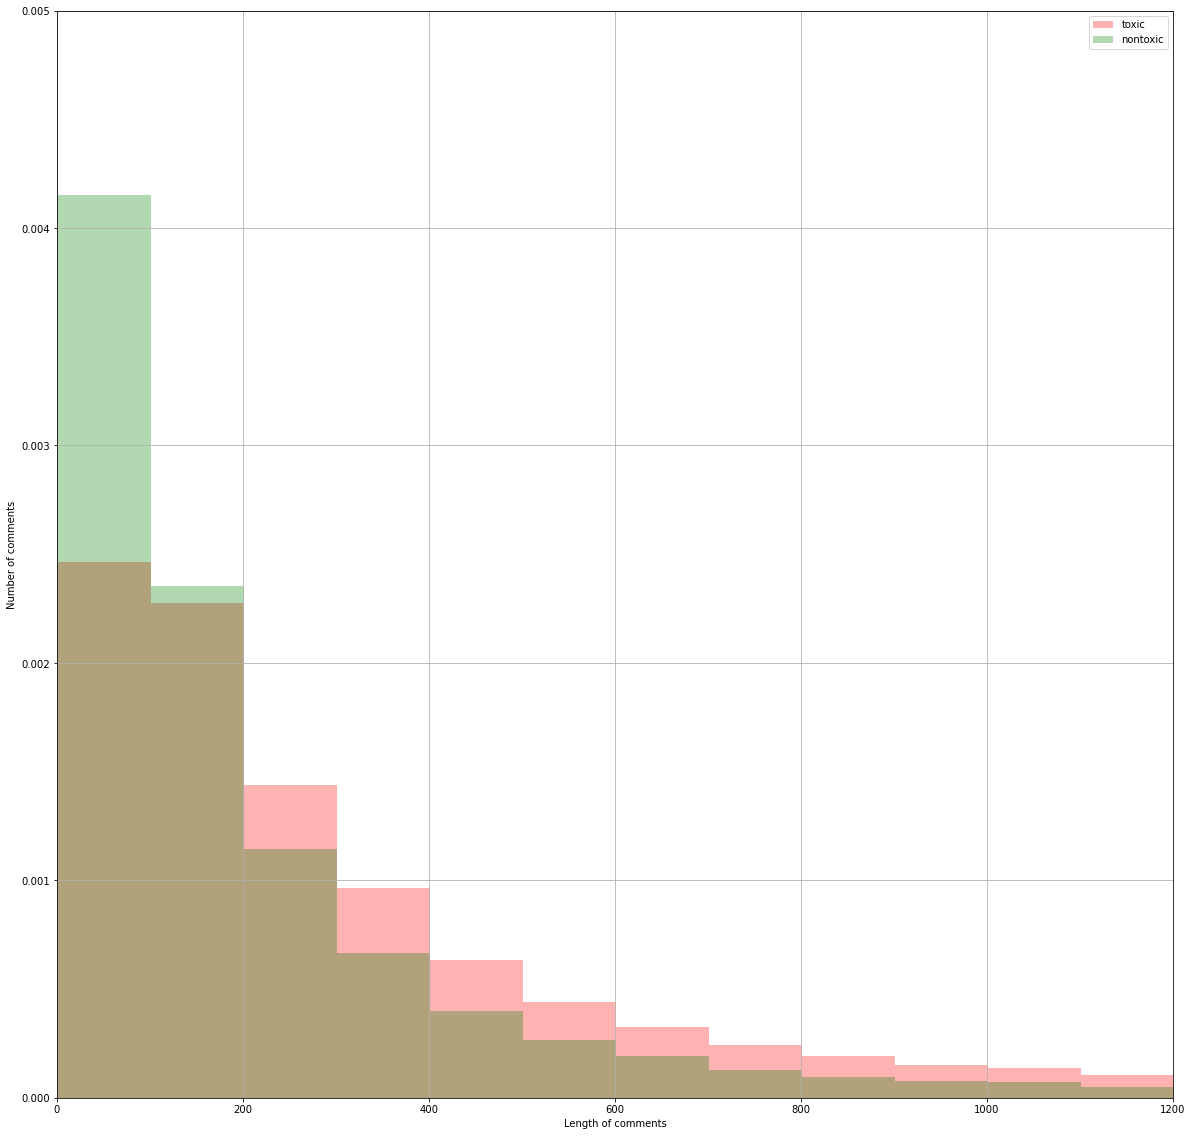

In [21]:
# Create the figure
plt.figure(figsize=(20,20))

# Get the data for the first plot
label = train[['istoxic']]
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    if label['istoxic'].iloc[ix] == 0:
        y[ix][0] = l

# Create the first plot
plt.hist(y, bins=range(1, 8000, 100), label='toxic', color='red', density = True, alpha=0.3)

# Get the data for the second plot
label = train[['istoxic']]
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    if label['istoxic'].iloc[ix] == 1:
        y[ix][0] = l

# Create the second plot
plt.hist(y, bins=range(1, 8000, 100), label='nontoxic', color='green', density = True, alpha=0.3)

# Set the x and y axis limits
plt.axis([0, 1200, 0, 0.005])

# Set the x and y labels
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

## TfidfVectorizer

The vectorizer is initialized with the following parameters:

- ngram_range: The range of n-grams to be extracted from the documents. In this case, only unigrams (single words) are extracted.
- max_features: The maximum number of features (i.e., unique words) to be extracted from the documents. In this case, only the most frequent 10,000 words will be used.
- min_df: The minimum number of documents that a word must appear in to be included in the matrix. In this case, a word must appear in at least 2 documents to be included.
- max_df: The maximum proportion of documents that a word can appear in to be included in the matrix. In this case, a word can appear in at most 70% of the documents.
- strip_accents: A flag that specifies whether to remove accent marks from the words in the documents. In this case, accent marks are removed.
- analyzer: The type of tokens (i.e., words, characters, or subwords) to be extracted from the documents. In this case, only words are extracted.
- stop_words: The list of stop words (i.e., common words that are not useful for text analysis) to be removed from the documents. In this case, the default English stop words list is used.

In [22]:
# Create a TfidfVectorizer object, which is a tool used to convert
# a collection of raw documents into a matrix of numerical values that represent
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000, min_df=3, max_df=0.99, 
                             strip_accents='unicode', analyzer='word', stop_words = 'english')
vectorizer.fit(train['comment_text'])

TfidfVectorizer(max_df=0.99, max_features=10000, min_df=3, stop_words='english',
                strip_accents='unicode')

In [23]:
X = vectorizer.transform(train['comment_text'])
y = train['istoxic']

In [24]:
print(train['comment_text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [25]:
vectorizer.get_feature_names()[4273]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'hardly'

In [26]:
# Train-test split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=21)

In [27]:
model = LogisticRegression()

model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
y_pred_test = model.predict(X_test)
y_pred_test

array([False, False, False, ..., False, False, False])

In [29]:
y_pred_train = model.predict(X_train)

In [30]:
model.coef_

array([[-0.17858095, -0.72187204, -0.05077082, ...,  0.29690302,
        -0.3010188 ,  0.88221749]])

## Prediction Scores

In [31]:
proba = model.predict_proba(X_test)[:, [1]]

In [32]:
mean_absolute_error(proba, y_test)

0.07756295362285404

In [33]:
metrics.mean_squared_error(proba, y_test, squared=False)

0.18540513649544918

In [34]:
metrics.mean_squared_error(proba, y_test, squared=True)

0.03437506463889614

In [35]:
model.score(X_train, y_train)

0.9594893418920492

In [36]:
np.mean(y_pred_train == y_train)

0.9594893418920492

In [37]:
model.score(X_test, y_test)

0.9545872326203209

In [38]:
np.mean(y_pred_test == y_test)

0.9545872326203209

In [39]:
test['istoxic'] = 0

In [40]:
# Create a TfidfVectorizer object, which is a tool used to convert
# a collection of raw documents into a matrix of numerical values that represent
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000, min_df=2, max_df=0.7, 
                             strip_accents='unicode', analyzer='word', stop_words = 'english')
vectorizer.fit(test['comment_text'])

X = vectorizer.transform(test['comment_text'])
y = test['istoxic']


In [41]:
y_pred1 = model.predict(X)

In [42]:
test['istoxic'] = y_pred1

In [43]:
test.head(10)

,id,comment_text,istoxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,False
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,False
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",False
3,00017563c3f7919a,":If you have a look back at the source, the in...",False
4,00017695ad8997eb,I don't anonymously edit articles at all.,False
5,0001ea8717f6de06,Thank you for understanding. I think very high...,False
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,False
7,000247e83dcc1211,:Dear god this site is horrible.,False
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",False
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,False


In [44]:
test.describe()

,id,comment_text,istoxic
count,153164,153164,153164
unique,153164,153164,2
top,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,False
freq,1,1,151843


In [45]:
test[test['istoxic']==True]['comment_text']

89        :Thanks for the comment about Wiki-defendernes...
241       " \n\n ===Use of ""Nepal Bhasa""=== \n The ter...
521       Kinsey's methods are called into question by s...
600       == Nosepicking == \n\n  \n I'm glad you apprec...
739       " \n\n == Norepi makes you think better == \n\...
                                ...                        
152444                   REDIRECT Talk:Green to Gold (book)
152524    I just wikified what was provided. If the orig...
152785    " \n\n calvin mcdonald  born january 16 1998)[...
152821    " \n ::I don't have a choice.  RL is fucking w...
152833    " \n\n BAD IDEA.   CF Alcock published an open...
Name: comment_text, Length: 1321, dtype: object

## Another Model

In [46]:
train1.head(10)

,id,comment_text,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False
9,00040093b2687caa,alignment on this subject and which are contra...,False


In [47]:
label = train[['istoxic']]
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    y[ix][0] = l

In [48]:
print(y)

[[264.]
 [112.]
 [233.]
 ...
 [ 81.]
 [116.]
 [189.]]


In [49]:
train1['len']=y

In [50]:
train1.head(10)

,id,comment_text,istoxic,len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,264.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,112.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,233.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,622.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,67.0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False,65.0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True,44.0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False,115.0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False,472.0
9,00040093b2687caa,alignment on this subject and which are contra...,False,70.0


In [51]:
train1['_istoxic']=train1['len']>200.0

In [52]:
train1.head(10)

,id,comment_text,istoxic,len,_istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,264.0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,112.0,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,233.0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,622.0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,67.0,False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False,65.0,False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True,44.0,False
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False,115.0,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False,472.0,True
9,00040093b2687caa,alignment on this subject and which are contra...,False,70.0,False


In [53]:
confusion_matrix = metrics.confusion_matrix(train1['istoxic'], train1['_istoxic'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

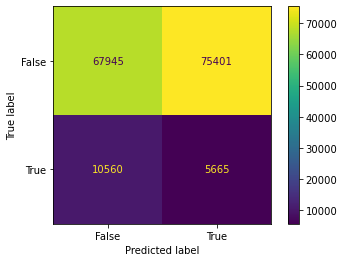

In [54]:
cm_display.plot()
plt.show()

In [55]:
print('Precision: %.3f' % precision_score(train1['istoxic'], train1['_istoxic']))

Precision: 0.070


In [56]:
print('Recall: %.3f' %  recall_score(train1['istoxic'], train1['_istoxic']))

Recall: 0.349


In [57]:
print('Accuracy: %.3f' % accuracy_score(train1['istoxic'], train1['_istoxic']))

Accuracy: 0.461


In [58]:
print('F1 Score: %.3f' % f1_score(train1['istoxic'], train1['_istoxic']))

F1 Score: 0.116
